<a href="https://colab.research.google.com/github/uol-mediaprocessing/group-projects-sudoku-solver/blob/master/main_sudoku.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sudoku Reader

In this project a software is developed which recognizes a Sudoku puzzle and solves it automatically.

![Sudoku Puzzle](https://github.com/uol-mediaprocessing/group-projects-sudoku-solver/blob/master/Aufgabe.jpg?raw=1)

## Group members:
* Justine Bruns (Business Informatics)

* Dennis Kempf (Computing Science)

* Mykhailo Ievreinov (Business Informatics)



# Milestones

## Define requirements

In which use cases is a Sudoku solver used?

## Detect Sudoku grid

1. Acquire input image to be analyzed
    1. Read static image from storage
    2. Use real time video stream (optional)

2. Preprocess input image for further analysis

3. Detect shape of Sudoku grid within preprocessed image

![Detect grid](https://github.com/uol-mediaprocessing/group-projects-sudoku-solver/blob/master/documentation/detect_grid.png?raw=1)

## Recognize digits

1. Apply perspective transformation to Sudoku grid

![](https://github.com/uol-mediaprocessing/group-projects-sudoku-solver/blob/master/documentation/transform_grid.png?raw=1)

2. Extract cells from grid image

![](https://github.com/uol-mediaprocessing/group-projects-sudoku-solver/blob/master/documentation/extract_cells.png?raw=1)

3. Recognize digits (1 to 9) within cells
    1. Recognize computer generated digits by classical means (e. g. template matching)
    2. Recognize handwritten digits using artificial neural networks (trained on MNIST dataset)
    3. Mark empty cells

![](https://github.com/uol-mediaprocessing/group-projects-sudoku-solver/blob/master/documentation/recognize_digits.png?raw=1)

## Solve puzzle

1. Store recognized digits within matrix data structure 

2. Feed data structure into existing Sudoku solver

![](https://github.com/uol-mediaprocessing/group-projects-sudoku-solver/blob/master/documentation/solve_puzzle.png?raw=1)

3. Output solution to user
    1. Print solved matrix in console
    2. Draw solution onto input image (AR, optional)

![](https://github.com/uol-mediaprocessing/group-projects-sudoku-solver/blob/master/documentation/output_ar.png?raw=1)

# Implementation
The following chapters describe the implementation of our Sudoku solver based on the requirements and milestones defined above.

## Acquire Input Images


Our goal is to solve a Sudoku puzzle which is contained within an image (or stream of images).
Thus, first of all, we have to acquire some images to be analyzed.
For the first part of this implementation, we will read a set of static images from our GitHub repository.

The corresponding URLs are defined by the following array.

In [0]:
input_image_urls = [
  "https://raw.githubusercontent.com/uol-mediaprocessing/group-projects-sudoku-solver/master/example_image.jpg"
]

We use the **scikit-image** library to download the images specified by the above array.
This library provides a method `io.imread` which reads images not only from local storage, but also from remote origins specified as URLs.
In contrast to OpenCV which encodes color images in BGR format, this method uses the more common RGB encoding.

In [0]:
from skimage import io
from os.path import basename

def download_image(url):
  print("Downloading", url, "...")
  filename = basename(url)
  image = io.imread(url) # encoded in RGB
  return { 
      "url": url,
      "filename": filename,
      "data": image
  }

The downloaded images are stored, together with some meta data, in a `DataFrame` provided by the **Pandas** library.

In [159]:
import pandas as pd

def download_all_images(urls):
  print("Downloading", len(urls), "images...")
  images = [download_image(x) for x in urls]
  return pd.DataFrame(images)

input_images = download_all_images(input_image_urls)
input_images.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 3 columns):
url         1 non-null object
filename    1 non-null object
data        1 non-null object
dtypes: object(3)
memory usage: 152.0+ bytes


For demonstration purposes the images are then displayed using the **matplotlib** library.

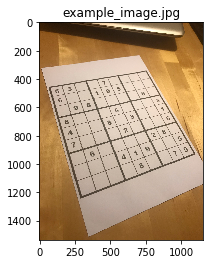

In [160]:
import matplotlib.pyplot as plt

def show_images(images, titles=[], cmap=None):
  for i, image in enumerate(images):
    if i < len(titles):
      plt.title(titles[i])
    plt.imshow(image, cmap=cmap)
    plt.show()

show_images(input_images["data"], titles=input_images["filename"])

## Preprocess Input Image
Within each of our input images we need to detect the Sudoku grid.
This detection will be done by analyzing the image contours using the **OpenCV2** library.
The `findContours` method requires the image to be binary, i. e. each pixel is completely black or completely white with no inbetween these two colors.
Based on these black and white regions contours/edges will be determined.
But our input images currently contain three color channels, namely **R**ed, **G**reen and **B**lue.
These have to be reduced in an favourable way that keeps the grid contours clearly recognizable.

We start by converting our RGB images to grayscale images using the method `cvtColor` provided by OpenCV.

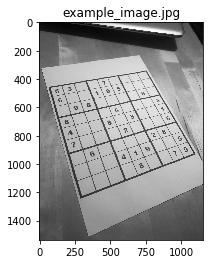

In [161]:
import cv2 as cv

def convert_to_grayscale(image):
  return cv.cvtColor(image, cv.COLOR_RGB2GRAY)

grayscale_input_images = [convert_to_grayscale(x) for x in input_images["data"]]
show_images(grayscale_input_images, titles=input_images["filename"], cmap="gray")

Grayscale images only have one "color" channel, but this one is still not binary.
For this reason we use thresholding, which maps values below some threshold x to "completely black" and values above x to "completely white".
More precisely we use a technique called "adaptive thresholding" which requires us to define a "block size".
The method `adaptiveThreshold` from OpenCV requires the block size to be specified by a number of pixels.
Because we accept different kinds of images with varying resolutions, we define it relative to the image resolution and then convert to an absolute number of pixels as required.


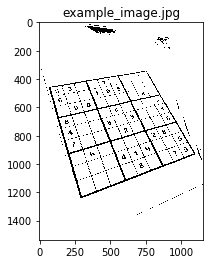

In [162]:
#@title Threshold Configuration { run: "auto" }
default_threshold_block_size = 0.5 #@param { type: "slider", min: 0, max: 1, step: 0.1 }
default_threshold_bias = 64 #@param { type:"slider", min: -255, max: 255, step: 1 }

def threshold_image(image, 
                    method=cv.ADAPTIVE_THRESH_GAUSSIAN_C,
                    block_size=default_threshold_block_size, 
                    bias=default_threshold_bias):
  # convert relative block size to absolute block size
  width, height = image.shape
  block_size = int(block_size * min(width, height))
  # if block_size is even, we must make it uneven (see def. of adaptiveThreshold)
  if block_size % 2 == 0:
    block_size += 1
  return cv.adaptiveThreshold(image, 255, method, cv.THRESH_BINARY, block_size, bias)

thresh_input_images = [threshold_image(x) for x in grayscale_input_images]
show_images(thresh_input_images, titles=input_images["filename"], cmap="gray")


## Detect Shape of Sudoku Grid
Finally we can try to detect the shape of a Sudoku grid within each image.
As previously mentioned we do this using the method `findContours` provided by OpenCV.

In [0]:
def find_contours(image):
  _, contours, _ = cv.findContours(image, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
  return contours

contours = [find_contours(x) for x in thresh_input_images]

The set of found contours can be visualized using the method `drawContours` provided by OpenCV.

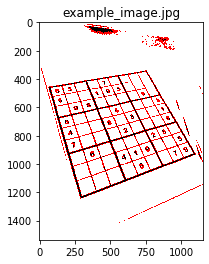

In [164]:
def draw_contours(image, contours):
  # convert image from grayscale to BGR
  image = cv.cvtColor(image, cv.COLOR_GRAY2BGR)
  # draw contours using OpenCV
  cv.drawContours(image, contours, -1, color=(0, 0, 255), thickness=2)
  return cv.cvtColor(image, cv.COLOR_BGR2RGB)

images_with_contours = [draw_contours(x, y) for x, y in zip(thresh_input_images, contours)]
show_images(images_with_contours, titles=input_images["filename"])

From all of the detected contours we now have to determine which contours are actually corresponding to our Sudoku grid.

**Assumption**: The Sudoku grid always has a square border.

**Idea:** A square has exactly four sides. Thus we can filter out all contours having less than or more than four sides.

The contours generated by `findContours` can be very *wiggly* causing us to overestimate the actual number of sides.
To counter that, we approximate all contours using the method `approxPolyDP` that is also provided by OpenCV.

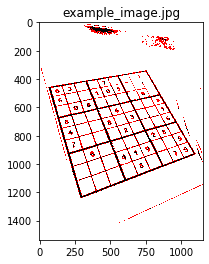

In [165]:
def approximate_contour(contour, precision=0.1):
  # convert relative precision to absolute precision (epsilon)
  _, _, width, height = cv.boundingRect(contour)
  epsilon = max(width, height) * precision
  return cv.approxPolyDP(contour, epsilon, closed=True)

approximated_contours = [[approximate_contour(y) for y in x] for x in contours]
images_with_contours = draw_all_contours(thresh_input_images, approximated_contours)
show_images(images_with_contours, titles=input_images["filename"])

Now we can actually filter out all contours that are not foursided.

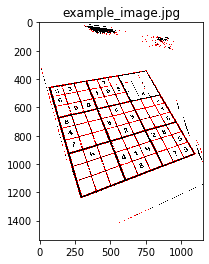

In [166]:
def get_foursided_contours(contours):
  candidates = []
  for contour in contours:
    if len(contour) != 4:
      continue
    candidates.append(contour)
  return candidates

foursided_contours = [get_foursided_contours(x) for x in approximated_contours]
images_with_contours = draw_all_contours(thresh_input_images, foursided_contours)
show_images(images_with_contours, titles=input_images["filename"])

But which of these foursided contours is our Sudoku square?

**Assumption:** The Sudoku grid is always the largest foursided object within all images.

**Idea:** Sort contours by circumference and choose the largest one.

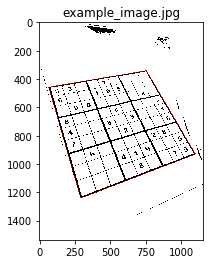

In [167]:
import numpy as np

def get_largest_contour(contours):
  lengths = [cv.arcLength(x, closed=True) for x in contours]
  longest = np.argmax(lengths)
  return contours[longest]

largest_contours = [get_largest_contour(x) for x in foursided_contours]
images_with_contours = [draw_contours(x, [y]) for x, y in zip(thresh_input_images, largest_contours)]
show_images(images_with_contours, titles=input_images["filename"])

# Do not look below this line, please!

**Assumption:** The Sudoku grid always has a black border.

**Idea:** Only preserve black (or mostly black) regions within each input image.

But what does it mean for something to be "black"?
In general we can say that something is "black" if it is "dark", i. e. has a low brightness value, and it is "greyish", i. e. has a low saturation value.


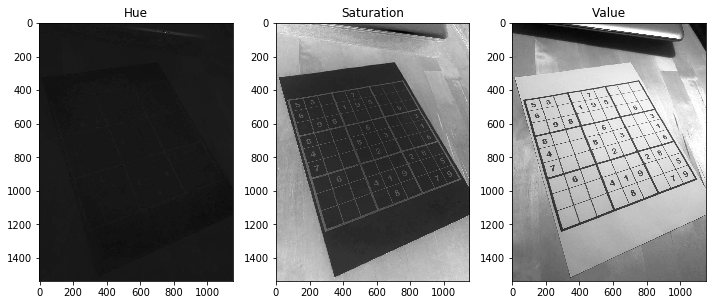

In [169]:
import cv2 as cv
import random

def show_hsv_channels(image):
  image = cv.cvtColor(image, cv.COLOR_RGB2HSV)
  h, s, v = image[:,:,0], image[:,:,1], image[:,:,2]
  plt.figure(figsize=(10, 10))
  plt.subplot(1, 3, 1)
  plt.title("Hue")
  plt.imshow(h, cmap="gray")
  plt.subplot(1, 3, 2)
  plt.title("Saturation")
  plt.imshow(s, cmap="gray")
  plt.subplot(1, 3, 3)
  plt.title("Value")
  plt.imshow(v, cmap="gray")
  plt.tight_layout()
  plt.show()

random_input_image = random.choice(input_images["data"])
show_hsv_channels(random_input_image)